In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
from pathlib import Path
import numpy as np
import torch
from torch.backends import cudnn

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Configuration

In [3]:
import torch.utils.model_zoo

MOPED_PATH = Path('')
LINEMOD_PATH = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/data/lm')
CHECKPOINT = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/checkpoints/latentfusion-release.pth')
num_input_views = 8

In [4]:
import sys
sys.path.insert(0,'../')

##########
checkpoint = CHECKPOINT
############

In [5]:
from latentfusion.recon.inference import LatentFusionModel

model = LatentFusionModel.from_checkpoint(checkpoint, device)

2022-06-20 11:49.04 [warning  ] could not import PCL           [latentfusion.pointcloud] 
2022-06-20 11:49.08 [info     ] loaded model                   [latentfusion.recon.inference] epoch=200 name=shapenet,no_mask_morph,fixed_eqlr,256,mask,depth,in_mask,mask_noise_p=0.25,sm=nearest,fuser=gru-branched_20200509_10h19m10s-branched_20200509_10h42m53s-branched_20200509_10h46m53s-branched_20200509_10h48m49s


In [6]:
from latentfusion.recon.inference import Observation
from latentfusion.pose import bop
from latentfusion.datasets.bop import BOPDataset
from latentfusion.datasets.realsense import RealsenseDataset
import latentfusion.visualization as viz
from latentfusion.augment import gan_denormalize
from latentfusion import meshutils
from latentfusion import augment

Adding Anaconda lib path:/home/amoghtiwari/miniconda3/envs/latentfusion/lib/


## Load Dataset

### LINEMOD

Uncomment this and comment out the MOPED cell to use LINEMOD.

In [7]:
object_id = 4
frame = 0
input_scene_path = LINEMOD_PATH / f'train/{object_id:06d}'
target_scene_path = LINEMOD_PATH / f'test/{object_id:06d}'

input_dataset = BOPDataset(LINEMOD_PATH, input_scene_path, object_id=object_id, object_scale=None)
print('object_scale', input_dataset.object_scale)
target_dataset = BOPDataset(LINEMOD_PATH, target_scene_path, object_id=object_id, object_scale=None)
object_scale_to_meters = 1.0 / (1000.0 * target_dataset.object_scale)
pointcloud = input_dataset.load_pointcloud()

object_scale 0.005797370312826102


In [8]:
input_scene_path

PosixPath('/ssd_scratch/cvit/amoghtiwari/latentfusion/data/lm/train/000004')

### MOPED

In [9]:
# object_id = 'toy_plane'
# frame = 100

# input_scene_dir = MOPED_PATH / object_id / 'reference'
# target_scene_dir = MOPED_PATH / object_id / 'evaluation'

# pointcloud_path = input_scene_dir / 'integrated_registered_processed.obj'
# obj = meshutils.Object3D(pointcloud_path)
# pointcloud = torch.tensor(obj.vertices, dtype=torch.float32)
# diameter = obj.bounding_diameter
# object_scale = 1.0 / diameter
# object_scale_to_meters = 1.0 / object_scale

# input_paths = [x for x in input_scene_dir.iterdir() if x.is_dir()]
# input_dataset = RealsenseDataset(input_paths,
#                                  image_scale=1.0,
#                                  object_scale=object_scale,
#                                  odometry_type='open3d')
# target_paths = sorted([x for x in target_scene_dir.iterdir() if x.is_dir()])
# target_dataset = RealsenseDataset(target_paths,
#                                   image_scale=1.0,
#                                   object_scale=object_scale,
#                                   odometry_type='open3d',
#                                   use_registration=True)

### Process Dataset into Observations

Here we load the data into the `Observation` class.

../latentfusion/modules/geometry.py:351: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1654413022026/work/aten/src/ATen/native/TensorShape.cpp:2890.)
  grids = bboxes_to_grid(boxes, in_size, out_size)


torch.Size([8, 1, 480, 640]) 256 3.8539541237809827
torch.Size([8, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827


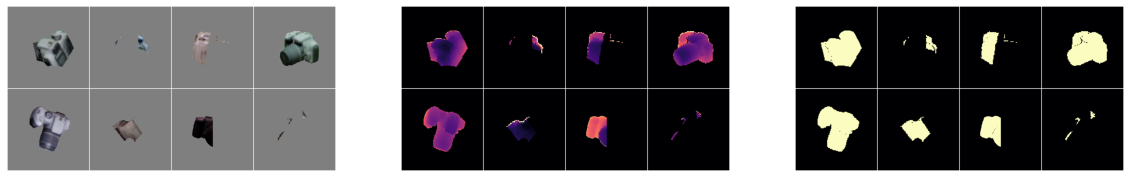

In [10]:
input_obs = Observation.from_dataset(input_dataset, inds=input_dataset.sample_evenly(num_input_views))
target_obs = Observation.from_dataset(target_dataset, inds=list(range(len(target_dataset)))[frame:frame+1])

input_obs_pp = model.preprocess_observation(input_obs)
input_obs_pp_gt = model.preprocess_observation(input_obs)
target_obs_pp = model.preprocess_observation(target_obs)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(gan_denormalize(input_obs_pp.color), nrow=4)
plt.subplot(132)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(input_obs_pp.mask), nrow=4)

## Build Latent Object

This builds the 'latent object', referred to as `z_obj` in this code.

recon_error 0.06770879775285721


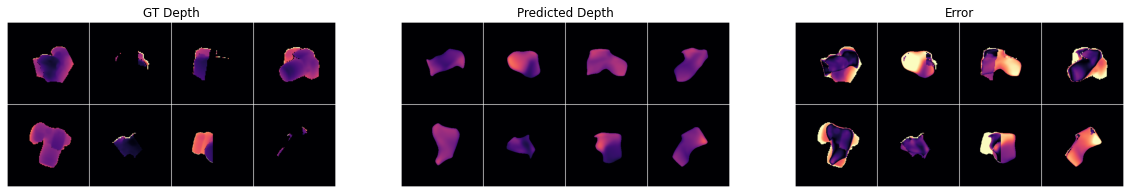

In [11]:
from latentfusion import three
import math

with torch.no_grad():
    z_obj = model.build_latent_object(input_obs_pp)

    # Visualize prediction.
    camera = input_obs_pp.camera.clone()
    y, z = model.render_latent_object(z_obj, camera.to(device))

recon_error = (y['depth'].detach().cpu() - input_obs_pp_gt.depth).abs()
print('recon_error', recon_error.mean().item())
    
plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4, title='GT Depth')
plt.subplot(132)
viz.show_batch(viz.colorize_depth(y['depth'].detach().cpu()), nrow=4, title='Predicted Depth')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(recon_error), nrow=4, title='Error')


### Visualize some novel views

This visualizes the object from novel views.

torch.Size([8, 1, 480, 640]) 256 3.8539541237809827


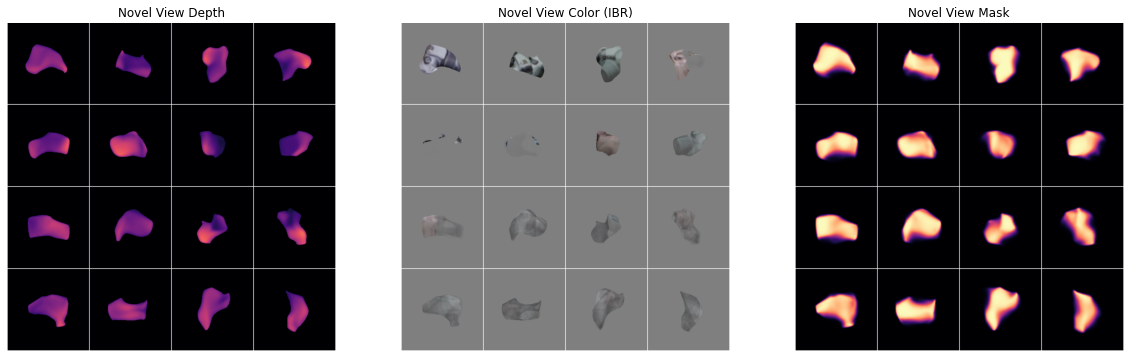

In [12]:
from latentfusion.three.orientation import evenly_distributed_quats
num_novel = 16
camera_ref = input_obs.camera[0]
camera_ref = camera_ref.zoom(None, model.camera_dist, model.input_size)
quats = evenly_distributed_quats(num_novel, upright=True).to(device)
camera_test = camera_ref.clone().repeat(num_novel)
camera_test.quaternion = quats

with torch.no_grad():
    y, _ = model.render_ibr_basic(z_obj, input_obs, camera_test.clone().to(device), apply_mask=True)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(y['depth']), nrow=4, title='Novel View Depth')
plt.subplot(132)
viz.show_batch(gan_denormalize(y['color'].cpu()), nrow=4, title='Novel View Color (IBR)')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(y['mask']), nrow=4, title='Novel View Mask')

## Coarse Pose Estimation

2022-06-20 11:49.14 [info     ] loading pose estimator from config [latentfusion.pose.estimation] init_hemisphere=False init_upright=False learning_rate=0.3 loss_weights={'depth': 0.0, 'ov_depth': 0.0, 'iou': 0.0, 'mask': 0.0, 'latent': 1.0} num_elites=48 num_gmm_components=6 num_iters=30 num_samples=96 ranking_size=16 return_camera_history=False sample_flipped=True type=cross_entropy verbose=False


torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([1, 1, 480, 640]) 256 3.8539541237809827
torch.Size([

2022-06-20 11:49.29 [info     ] best camera                    [latentfusion.pose.estimation] loss=0.7664179801940918 step=26


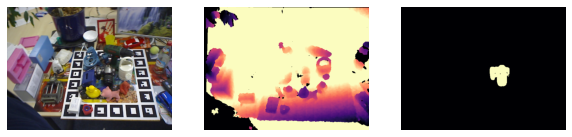

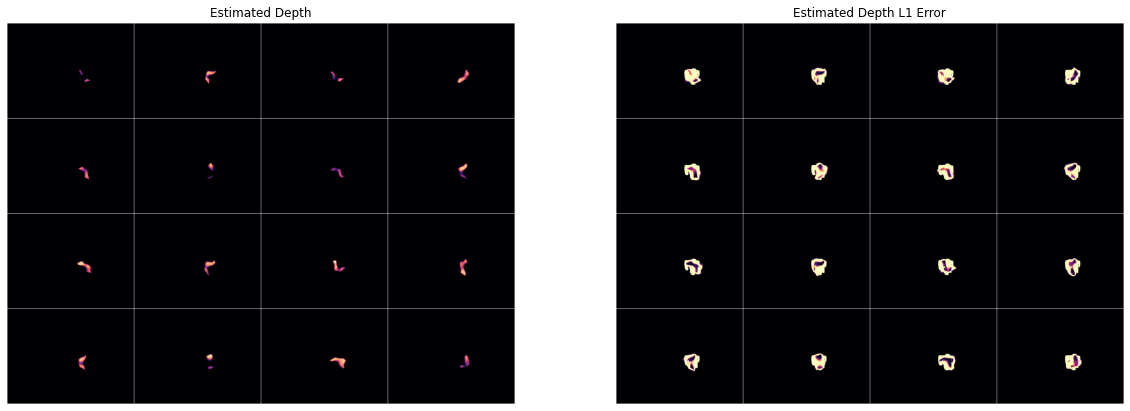

In [13]:
import latentfusion.pose.estimation as pe
from functools import partial

estimator = pe.load_from_config('../configs/cross_entropy_latent.toml', model, return_camera_history=False, verbose=False)

coarse_camera = estimator.estimate(z_obj, target_obs[0])
camera_zoom = coarse_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.
pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * pred_mask
pred_depth, _ = camera_zoom.uncrop(pred_depth)
pred_mask, _ = camera_zoom.uncrop(pred_mask)
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()

plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth.cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask.cpu()), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

### Fine Pose Estimation

2022-06-20 11:49.31 [info     ] loading pose estimator from config [latentfusion.pose.estimation] converge_patience=10 converge_threshold=1e-06 learning_rate=0.01 loss_weights={'depth': 1.0, 'ov_depth': 0.3, 'iou': 0.0, 'mask': 0.0, 'latent': 0.0} lr_reduce_patience=10 lr_reduce_threshold=0.0001 num_iters=100 num_samples=8 optimizer=adam ranking_size=8 return_camera_history=True track_stats=True type=gradient


2022-06-20 11:49.53 [info     ] convergence threshold reached  [latentfusion.pose.estimation] count=10 delta=0.0 step=90


2022-06-20 11:49.53 [info     ] best camera                    [latentfusion.pose.estimation] loss=0.15540578961372375 step=80


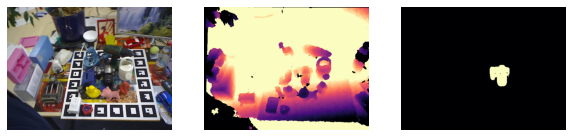

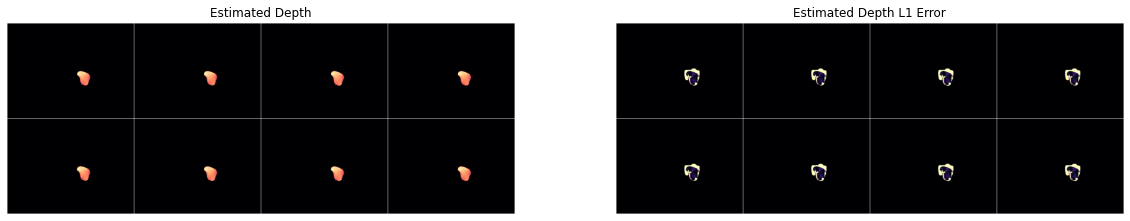

In [14]:
from latentfusion import utils
from latentfusion.pose import utils as pose_utils
from latentfusion.modules.geometry import Camera

sgd_estimator = pe.load_from_config('../configs/adam_quick.toml', model, track_stats=True, return_camera_history=True, num_iters=100)

init_camera = coarse_camera.clone()
refined_camera, stat_history, camera_history = sgd_estimator.estimate(z_obj, target_obs[0], camera=init_camera)
camera_zoom = refined_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.
pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * (pred_y['mask'].squeeze(0) > 0.5)
pred_depth, _ = camera_zoom.uncrop(pred_depth)
pred_mask, _ = camera_zoom.uncrop(pred_mask)
depth_error = (target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()
depth_error = depth_error.cpu()


plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth, cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

In [15]:
from latentfusion.pose.metrics import camera_metrics
from latentfusion.pose.format import metrics_table_multiple


for j in range(1):
    print(metrics_table_multiple([
            camera_metrics(target_obs.camera, coarse_camera[j], pointcloud, object_scale_to_meters),
            camera_metrics(target_obs.camera, refined_camera[j], pointcloud, object_scale_to_meters),
    ], ['Coarse', 'Refined'], tablefmt='simple'))

         Rotation Error    Translation Error    ADD       ADD (sym)    ADD-S     Proj2D
-------  ----------------  -------------------  --------  -----------  --------  --------
Coarse   165.29°           0.0122 m             0.0932 m  0.0932 m     0.0183 m  37.72 px
Refined  178.28°           0.0092 m             0.0998 m  0.0746 m     0.0154 m  40.80 px


### Plot pose refinement stats over time

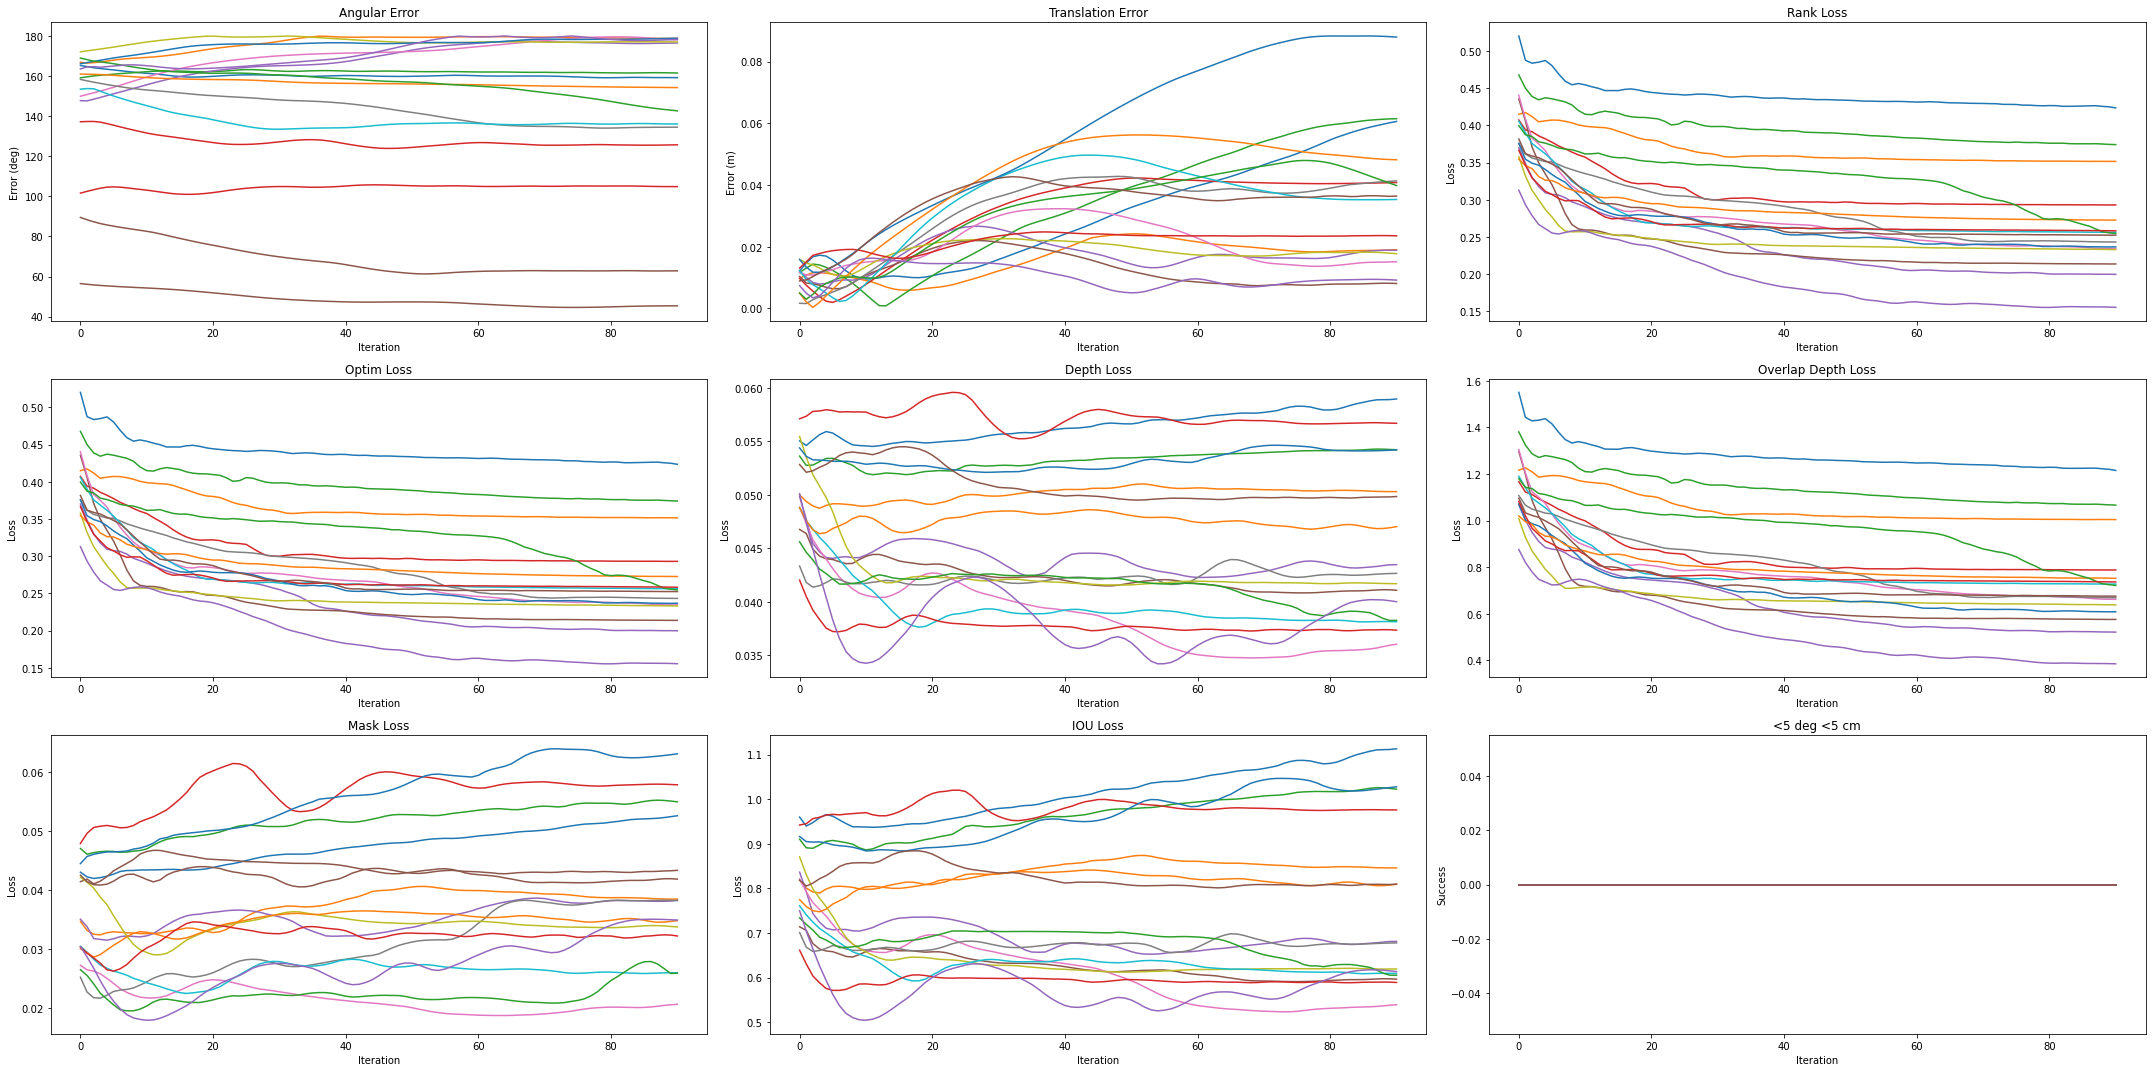

In [16]:
import math

viz.plot_grid(3, figsize=(30, 15), plots=[
    viz.Plot('Angular Error', [stat_history['angle_dist']/math.pi*180], 
             params={'ylabel': 'Error (deg)', 'xlabel': 'Iteration'}),
    viz.Plot('Translation Error', [stat_history['trans_dist']*object_scale_to_meters], 
             params={'ylabel': 'Error (m)', 'xlabel': 'Iteration'}),
    viz.Plot('Rank Loss', [stat_history['rank_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Optim Loss', [stat_history['optim_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    
    viz.Plot('Depth Loss', [stat_history['depth_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Overlap Depth Loss', [stat_history['ov_depth_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Mask Loss', [stat_history['mask_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('IOU Loss', [stat_history['iou_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('<5 deg <5 cm', [(stat_history['trans_dist']*object_scale_to_meters < 0.05) & (stat_history['angle_dist']/math.pi*180 < 5)], 
             params={'ylabel': 'Success', 'xlabel': 'Iteration'}),
]);